In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

## Data preprocessing

- Data munging
- Visualisation
- Statistical analysis

In [2]:
train_data = pd.read_csv('data/sign_mnist_train.csv')
test_data = pd.read_csv('data/sign_mnist_test.csv')

In [3]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [3]:
# img dimensions
SIZE = (28, 28)
CLASSES = dict(zip(range(0, 26), list(map(chr, range(97, 123))))) # labels from A to Z

In [4]:
def preprocess_data(data):
    labels, images = data[0:, 0], np.array([np.reshape(i[1:], SIZE) for i in data.astype(np.uint8)])
    return images, labels

In [5]:
X_train, y_train = preprocess_data(train_data.to_numpy())
X_test, y_test = preprocess_data(test_data.to_numpy())

y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

y_train = np.eye(len(CLASSES))[y_train]
y_test = np.eye(len(CLASSES))[y_test]

X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [35]:
# Preprocess data to be within 0-1 range
train_images = X_train / 255.0
test_images = X_test / 255.0

In [ ]:
def show_image(mat, label):
    plt.xlabel(CLASSES[label], color='black')
    plt.imshow(mat, cmap=plt.cm.binary)
    plt.show()

for i in range(2):
    show_image(X_train[i], y_train[i])

## Building the model

In [7]:
def get_predicted_class(model, img):
    # img = cv.resize(img, SIZE)
    prediction = model.predict(np.array([img]))
    return CLASSES[np.argmax(prediction)]

In [8]:
model_params2 = [
    keras.layers.Conv2D(filters=8, kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(28,28, 1),activation='relu', data_format='channels_last'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.MaxPooling2D(pool_size=(4,4)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(26, activation='softmax')
]

params2 = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'SGD',
    'metrics': ['accuracy']
}

In [9]:
# prepare the model
model_params = [
    keras.layers.Flatten(input_shape=SIZE),  # input layer  (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (3)
    keras.layers.Dense(26, activation='softmax') # output layer (4) (26 classes/letters)
]
params = {
    'loss':keras.losses.SparseCategoricalCrossentropy(), # https://keras.io/api/losses/probabilistic_losses/#sparse_categorical_crossentropy-function
    'optimizer':keras.optimizers.Adam(learning_rate=0.001), # https://keras.io/api/optimizers/adam/
    'metrics':['accuracy']
}

In [10]:
model = keras.Sequential(model_params2)
model.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 3, 3, 128)         2

In [12]:
# compile the model with params
model.compile(**params2)

# train the model with the train data
# history = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=20)
history = model.fit(X_train, y_train, epochs=50, batch_size=100)

Epoch 1/50
275/275 [==============================] - 12s 39ms/step - loss: 3.0837 - accuracy: 0.0947
Epoch 2/50
275/275 [==============================] - 11s 41ms/step - loss: 3.0883 - accuracy: 0.0815
Epoch 3/50
275/275 [==============================] - 10s 35ms/step - loss: 2.4323 - accuracy: 0.2693
Epoch 4/50
275/275 [==============================] - 9s 31ms/step - loss: 1.6958 - accuracy: 0.4794
Epoch 5/50
275/275 [==============================] - 10s 35ms/step - loss: 1.3887 - accuracy: 0.5700
Epoch 6/50
275/275 [==============================] - 10s 37ms/step - loss: 0.9542 - accuracy: 0.6911
Epoch 7/50
275/275 [==============================] - 12s 44ms/step - loss: 0.8262 - accuracy: 0.7341
Epoch 8/50
275/275 [==============================] - 12s 42ms/step - loss: 0.6956 - accuracy: 0.7703
Epoch 9/50
275/275 [==============================] - 11s 41ms/step - loss: 0.6213 - accuracy: 0.7951
Epoch 10/50
275/275 [==============================] - 12s 42ms/step - loss: 0.5672

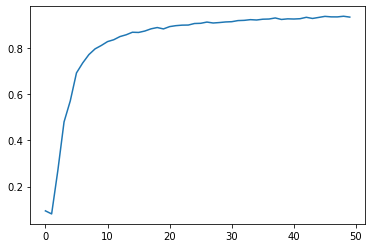

In [13]:
# plot history
plt.plot(history.history['accuracy'])

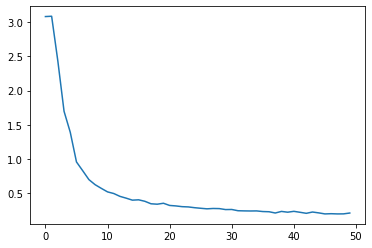

In [14]:
plt.plot(history.history['loss'])

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test,  y_test, batch_size=32)
print(f"Accuracy : {round(accuracy*100, 3)}%")

225/225 [==============================] - 5s 10ms/step - loss: 0.4536 - accuracy: 0.8652
Accuracy : 86.517%


Testing the model

In [16]:
'''
returns an array of predictions
shape -> (prediction data len, no of classes)
each index of the inner array pointing to the index of the CLASS variable
'''
predictions = model.predict(X_test) # make prediction
predictions.shape

(7172, 26)

In [17]:
# check the accuracy of the model
from termcolor import colored

batch = 20
loss = 0

if batch > len(X_test):
    print(f"Batch size is greater than the test data size.\nBatch size : {batch}\nTest data size : {len(X_test)}")
    batch = 10

for i in range(batch):
    prediction = model.predict(np.array([X_test[i]]))
    # print(CLASSES[np.argmax(prediction)], "->", CLASSES[np.argmax(y_test[i])])
    predicted_class, actual_class = CLASSES[np.argmax(prediction)], CLASSES[np.argmax(y_test[i])]

    # checks for the classes and sets color's depending on that
    color = 'green' if predicted_class == actual_class else 'red'
    if color == 'red': loss += 1
    print(colored(f'[{i}] Predicted : {predicted_class : <2}|  Expected : {actual_class}', color))

perc = round(100/(batch/(batch-loss)), 3)
print(f"Accuracy {perc}%\nLoss : {100-perc}%")

[0] Predicted : g |  Expected : g
[1] Predicted : f |  Expected : f
[2] Predicted : k |  Expected : k
[3] Predicted : a |  Expected : a
[4] Predicted : d |  Expected : d
[5] Predicted : v |  Expected : v
[6] Predicted : k |  Expected : k
[7] Predicted : o |  Expected : o
[8] Predicted : d |  Expected : d
[9] Predicted : h |  Expected : h
[10] Predicted : i |  Expected : i
[11] Predicted : i |  Expected : i
[12] Predicted : s |  Expected : v
[13] Predicted : m |  Expected : m
[14] Predicted : h |  Expected : h
[15] Predicted : e |  Expected : e
[16] Predicted : w |  Expected : w
[17] Predicted : a |  Expected : a
[18] Predicted : h |  Expected : h
[19] Predicted : h |  Expected : h
Accuracy 95.0%
Loss : 5.0%


In [18]:
# save model
model.save('models/CNNmodel.h5')